### Step 1: 下载数据

In [1]:
%matplotlib inline

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange

url = 'http://mattmahoney.net/dc/'

def download(filename):
    print('Starting downloading data ...')
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
    print('Data downloaded!')
    return filename

def maybe_download(filename, expected_bytes):
    """Download a file if not present or size is incorrect."""
    if not os.path.exists(filename):
        filename = download(filename)
    else:
        if os.stat(filename).st_size != expected_bytes:
            os.remove(filename)
            filename = download(filename)
    
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')        
    return filename

filename = maybe_download('/tmp/data/text8.zip', 31344016)
print("Data prepared!")

('Found and verified', 'text8.zip')
Data prepared!


### Step 2: 划分单词

In [2]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = f.read(f.namelist()[0]).split()
    return data

words = read_data(filename)
print('Data size', len(words))

('Data size', 17005207)


### Step 3: 建立词典，并且把低频单词替换成UNK

In [3]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0    # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words    # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156])


### Step 4: 定义产生训练Batch的函数

In [4]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1    # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window    # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print(generate_batch(4, 2, 1))
print(generate_batch(6, 3, 2))

(array([3084, 3084,   12,   12], dtype=int32), array([[5239],
       [  12],
       [3084],
       [   6]], dtype=int32))
(array([46, 46, 46, 59, 59, 59], dtype=int32), array([[   2],
       [  59],
       [3137],
       [ 128],
       [3137],
       [ 156]], dtype=int32))


### Step 5: 建立神经网络

In [5]:
import tensorflow as tf

# Training input data.
batch_size = 128
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# Validate input data.
valid_size = 8        # Random set of words to evaluate similarity on.
valid_window = 100    # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs.
embedding_size = 128    # Dimension of the embedding vector.
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
num_sampled = 64        # Number of negative examples to sample.
loss = tf.reduce_mean(tf.nn.nce_loss(
        nce_weights, nce_biases, embed, train_labels, num_sampled, vocabulary_size))

# Construct the SGD optimizer using a learning rate of 1.0.
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

# Output evaluation result
def print_eval_result():
    sim = similarity.eval()
    for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = "%s %s," % (log_str, close_word)
        print(log_str) 

print_eval_result()        

Nearest to states: europe, semantically, overseers, amplified, lans, ruhollah, lumumba, genitals,
Nearest to s: movements, blum, carpet, eutyches, corroborating, emanated, cook, costing,
Nearest to six: observes, defectors, feldman, shemini, salm, opaque, suggesting, sufferer,
Nearest to he: delft, meaningless, foo, coupon, au, maccabeus, flashing, mebyon,
Nearest to most: browne, solids, spores, anabolic, latency, fuses, distinguishing, hemlock,
Nearest to which: xlii, balm, coupling, bwv, rogers, dam, stanford, forerunners,
Nearest to known: lubricant, inorganic, whirlpool, intercepts, esa, lesser, mussels, bonus,
Nearest to system: nndb, spike, seminar, handed, astronomical, categorized, pastures, beckham,


### Step 6: 训练神经网络

In [6]:
num_steps = 100001

average_loss = 0
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 5000 == 0:
        if step > 0: average_loss /= 5000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print("Average loss at step ", step, ": ", average_loss)
        average_loss = 0

    if step % 20000 == 0:
        print("Validate evaluation result at at step ", step)
        print_eval_result()

final_embeddings = normalized_embeddings.eval()
sess.close()

('Average loss at step ', 0, ': ', 271.262939453125)
('Validate evaluation result at at step ', 0)
Nearest to states: europe, semantically, overseers, amplified, lans, ruhollah, lumumba, genitals,
Nearest to s: movements, blum, carpet, eutyches, corroborating, emanated, cook, costing,
Nearest to six: observes, defectors, feldman, shemini, salm, opaque, suggesting, sufferer,
Nearest to he: delft, meaningless, foo, coupon, au, maccabeus, flashing, mebyon,
Nearest to most: browne, solids, spores, anabolic, latency, fuses, distinguishing, hemlock,
Nearest to which: xlii, balm, coupling, bwv, rogers, dam, stanford, forerunners,
Nearest to known: lubricant, inorganic, whirlpool, intercepts, esa, lesser, mussels, bonus,
Nearest to system: nndb, spike, seminar, handed, astronomical, categorized, pastures, beckham,
('Average loss at step ', 5000, ': ', 73.462702681922906)
('Average loss at step ', 10000, ': ', 23.156379136943816)
('Average loss at step ', 15000, ': ', 12.294102747011184)
('Aver

### Step 7: 可视化结果

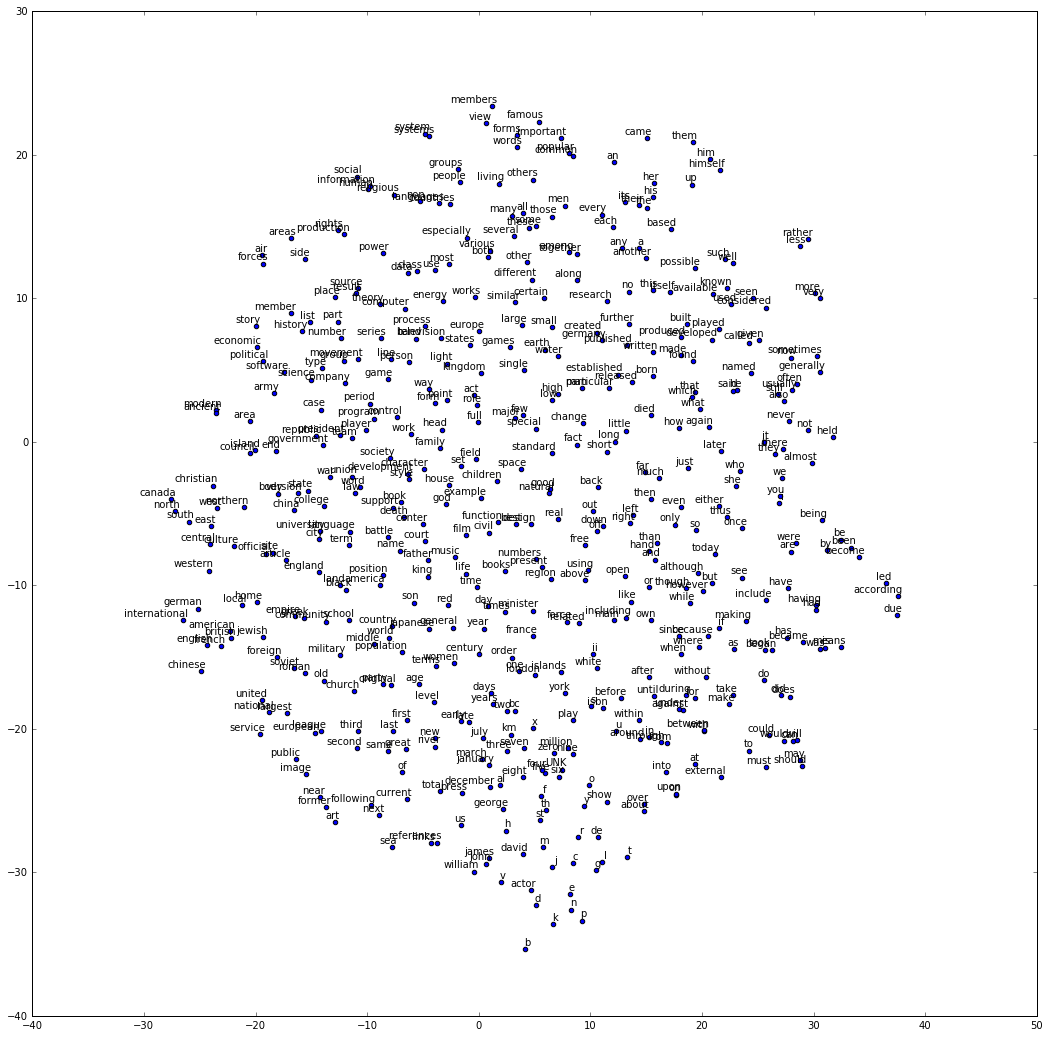

In [7]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    
    plt.savefig(filename)
    plt.show()

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")